## Import Libraries

In [44]:
import jax
import jax.numpy as jnp
from jax import lax
import immrax as irx
from scipy.interpolate import interp1d
import numpy as np
from scipy.io import loadmat
from functools import partial

## Load Data

In [45]:
# Control Data
data = loadmat('export_for_verification/data1.mat')
T_des = data['T_brk'][0]
U_des = data['U_brk']
Z_des = data['Z_brk']


# Obstacle Data
obstacle = loadmat('export_for_verification/obs1.mat')
O = obstacle['O']
O_buf = obstacle['O_buf']
O_pts = obstacle['O_pts']

U_des = U_des.T
Z_des = Z_des.T # fix row lengths to match T_des


In [46]:

print(T_des.shape)
print(Z_des.shape)

(94,)
(94, 4)


## Define Helper Functions

In [47]:
def saturate_input(u):
    turtlebot_max_yaw_rate = 2.0 # rad/s
    turtlebot_max_accel = 2.0 # m/s^2

    min_rate = -turtlebot_max_yaw_rate
    max_rate = turtlebot_max_yaw_rate
    min_accel = -turtlebot_max_accel
    max_accel = turtlebot_max_accel

    print(u.shape)

    mins = jnp.array([min_rate, min_accel])
    maxs = jnp.array([max_rate, max_accel])

    return jnp.clip(u, mins, maxs)


def rotation_matrix_2D(theta):
    return jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                      [jnp.sin(theta), jnp.cos(theta)]])

# @partial(jax.jit, static_argnames=('interp_mode',))
def match_trajectories(T_des, *varargin, interp_mode='linear'): #match_trajectories(t_fdbk, T_des, U_des, T_des, Z_des, 'previous')
    # T_des = varargin[0]
    # T_des = jnp.array([T_des])
    # print(f"T_des: {T_des}")

    numout = len(varargin) // 2

    out = []
    
    for i in range(numout) :
        T, Z = varargin[2*i], varargin[2*i+1]
        print(T_des.shape)
        print(T.shape, Z.shape)
        out.append(jnp.array([jnp.interp(T_des, T, Z[:,i], left=Z[0,i], right=Z[-1,i]) for i in range(Z.shape[1])]))
        # def _Tin () :
        #     f = jnp.interp(T_des, T, Z, left=Z[0], right=Z[-1])
        # def _Tnotin () :
        #     pass
        # out.append(lax.cond(jnp.logical_and(T_des >= T[0], T_des <= T[-1]), _Tin, _Tnotin))
        
    return out

    # output = []
    # out_idx = 1
    # for idx in range(0,len(varargin),2):
    #     # get the current time and trajectory
    #     T = varargin[idx]
    #     # print('here')
    #     # print(T)
    #     Z = varargin[idx+1]
        
    #     # if T_des exceeds the bounds of T, pad T and Z accordingly
    #     if T_des[0] < T[0]:
    #         T = [T_des[0], T]
    #         Z = [Z[:,0], Z]
    #         # print('here1')
        
    #     if T_des[-1] > T[-1]:
    #         T = [T, T_des[-1]]
    #         Z = [Z, Z[:,-1]]
    #         # print('here2')
        

    #     if len(T) == 1 and T_des == T:
    #         # check if no interpolation is needed (this resolves a bug
    #         # where interp1 reinterprets the length of Z as a vector to be
    #         # interpolated, and throws an error because T and Z are not of
    #         # the same length)
    #         output[out_idx] = Z
    #     else:
    #         # call interp1 as usual
    #         x = T
    #         y = Z
    #         # print(f"x: {x}")
    #         # print(f"y: {y}")
    #         f = interp1d(x, y, kind=interp_mode)
    #         x_new = T_des
    #         # print(f"x_new: {x_new}")
    #         y_new = f(x_new)
    #         # print(f"y_new: {y_new.shape}")

    #         output.append(y_new)
    #         # print(f"output: {output}")

    # return output


In [48]:
def get_control_inputs(t_curr, z_curr):
    # define gains
    k_p = 9
    k_v = 12
    k_a = 1
    k_h = 1
    k_w = 1
    k_hp = 0
    
    # define parameters
    t_lkhd = 0.01
    t_fdbk = jnp.minimum(t_curr + t_lkhd, T_des[-1])
    # print(f"t_curr: {t_curr}")
    # print(f"t_lkhd: {t_lkhd}")
    # print(f"T_des[-1]: {T_des[-1]}")
    # print(f"t_fdbk: {t_fdbk}")

    # get current state
    print(z_curr.shape)
    p_cur = z_curr[0:2]
    h_cur = z_curr[2]
    v_cur = z_curr[3]
    # print(f"p_cur: {p_cur.shape}")

    # get desired state and inputs (assumes zero-order hold)
    # we are doing feedback about a desired trajectory
    [u_des, z_des] = match_trajectories(t_fdbk, T_des, U_des, T_des, Z_des, interp_mode='previous')
    p_des = z_des[0:2]
    v_des = z_des[3]
    h_des = z_des[2]
    # print(f"p_des: {p_des}")
    # print(f"v_des: {v_des}")
    # print(f"h_des: {h_des}")
    print(f"u_des: {u_des}")
    print(f"z_des: {z_des}")
    # print(f"z_des: {z_des.shape}")

    # get desired feedforward inputs
    w_des = u_des[0]
    a_des = u_des[1]


    # compute position error in heading direction
    # print(f"h_cur: {h_cur.shape}")
    # print(f"h_cur: {h_cur}")
    R = rotation_matrix_2D(h_cur)

    # print(f"R.shape: {R.shape}")
    x = p_des - p_cur
    # print(f"p_des: {p_des.shape}")
    # print(f"p_cur: {p_cur.shape}")
    # print(f"x: {x.shape}")


    p_err = R@x
    # print(f"p_err: {p_err.shape}")
    px_err = p_err[0]
    
    # compute heading relative to desired position
    # hp_err = -jnp.atan2(p_err[1],p_err[0])
    hp_err = jnp.atan(p_err[1]/p_err[0])


    # compute unsaturated inputs (they get saturated by the agent)
    w_out = k_h*(h_des - h_cur) + k_w*w_des + k_hp*hp_err
    a_out = k_p*px_err + k_v*(v_des - v_cur) + k_a*a_des

    print(f'{w_out=}, {a_out=}')
    U = jnp.array([w_out, a_out])
    # print(f"U: {U}")
    return U




### Now Test Everything We've Done So Far

In [49]:
t_curr = 0
# t_curr = 0.135999766496351
z_curr = np.array([0, 0, 0, 0.5])#.reshape(4,1)

# z_curr = np.array([0.0861592989366947, 0.00631981201603120, 0.134176653731968, 0.727239913556463]).reshape(4,1)
# t_fdbk = 0.0102
t_lkhd = 0.01
U = get_control_inputs(t_curr, z_curr)
print(U)
final_u = saturate_input(U.squeeze())
print(f"final_u: {final_u}")




(4,)
()
(94,) (94, 2)
()
(94,) (94, 4)
u_des: [0.9979048 0.       ]
z_des: [8.4991856e-03 4.2407242e-05 9.9790478e-03 8.4993267e-01]
w_out=Array(1.0078838, dtype=float32), a_out=Array(4.275685, dtype=float32)
[1.0078838 4.275685 ]
(2,)
final_u: [1.0078838 2.       ]


In [50]:
# All of the above code is used to define the function u_map
def u_map(t,z):
    # u = irx.interval(get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des).squeeze())
    u_des = get_control_inputs(t, z)
    u_sat = saturate_input(u_des)
    # u_sat = t*jnp.ones(2)
    print(f"u_sat: {u_sat}")
    return u_sat

# w_map right now is empty, but ready for future implementation where we'd like to see noise
def w_map(t, z):
    return jnp.array([0., 0.])

In [51]:
u_map(t_curr, z_curr)

iz_curr = irx.icentpert(z_curr, 0.01)
print(iz_curr)

print(irx.natif(u_map)(irx.interval(0.), iz_curr))

iu_map = irx.natif(u_map)
# iw_map = irx.natif(w_map)
iw_map = lambda t, x : irx.icentpert([0., 0.], [0.01, 0.2])

(4,)
()
(94,) (94, 2)
()
(94,) (94, 4)
u_des: [0.9979048 0.       ]
z_des: [8.4991856e-03 4.2407242e-05 9.9790478e-03 8.4993267e-01]
w_out=Array(1.0078838, dtype=float32), a_out=Array(4.275685, dtype=float32)
(2,)
u_sat: [1.0078838 2.       ]
[[(-0.01      , 0.01      )]
 [(-0.01      , 0.01      )]
 [(-0.01      , 0.01      )]
 [( 0.49000001, 0.50999999)]]
(4,)
()
(94,) (94, 2)
()
(94,) (94, 4)
u_des: Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=2/0)>
z_des: Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=2/0)>
w_out=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, a_out=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
(2,)
u_sat: Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=2/0)>
[[(0.9978838, 1.01788378)]
 [(2.       , 2.        )]]


In [52]:

class TurtleBot (irx.ControlledSystem) :
    def __init__ (self) :
        self.evolution = 'continuous'
        self.xlen = 4

    def f(self, t, x, u, w):
        print(f"x: {x}")
        print(f"u: {u}")
        px, py, h, v = x.squeeze()
        u1, u2 = u.squeeze()
        w1, w2 = w

        xd = v*jnp.cos(h) + w1
        yd = v*jnp.sin(h) + w2
        hd = u1
        vd = u2

        zd = jnp.array([xd, yd, hd, vd])
        return zd

class TurtleBotControl (irx.Control) :
    def u (self,t,x) :
        return u_map(t,x)


olsys = TurtleBot()
control = TurtleBotControl()
sys = irx.ControlledSystem(olsys, control)
embsys = irx.natemb(sys)
# embsys = irx.mjacemb(sys)

# def func(t,y,args):
#     return f(t,y,u_map(t,y))

# # func = lambda t, y, input: f(t,y, input)
# print("in f")

# out = func(t_curr, z_curr, None)
# print(f"out: {out}")

In [53]:
from diffrax import diffeqsolve, ODETerm, Dopri5, Tsit5, Euler, SaveAt, AbstractSolver
import jax.numpy as jnp

t0 = 0.0
tf = T_des[-1]
dt = 0.01
print(f"t0: {t0}")
print(f"tf: {tf}")
print(f"dt: {dt}")

# term = ODETerm(func)
# # print(f"term: {term}")
# solver = Dopri5()
# y0 = jnp.array([0., 0., 0.,.5])
# saveat = SaveAt(t0=True, t1=True, steps=True)
# traj = diffeqsolve(term, solver, t0=t0, t1=tf, dt0=0.01, y0=y0, saveat=saveat)
# traj = sys.compute_trajectory(t0, tf, z_curr, (u_map, w_map), dt, solver='rk45')
# embtraj = embsys.compute_trajectory(t0, tf, irx.i2ut(iz_curr), (iu_map, iw_map), dt, solver='rk45')
traj = sys.compute_trajectory(t0, tf, z_curr, (w_map,), dt, solver='rk45')
embtraj = embsys.compute_trajectory(t0, tf, irx.i2ut(iz_curr), (iw_map,), dt, solver='rk45')

t0: 0.0
tf: 0.9249663441924902
dt: 0.01
(4,)
()
(94,) (94, 2)
()
(94,) (94, 4)
u_des: Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=4/0)>
z_des: Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=4/0)>
w_out=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=4/0)>, a_out=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=4/0)>
(2,)
u_sat: Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=4/0)>
x: Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=4/0)>
u: Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=4/0)>
(4,)
()
(94,) (94, 2)
()
(94,) (94, 4)
u_des: Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=4/0)>
z_des: Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=4/0)>
w_out=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=4/0)>, a_out=Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=4/0)>
(2,)
u_sat: Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=4/0)>
x: Traced<

In [54]:
tfinite = jnp.where(jnp.isfinite(traj.ts))
tt = traj.ts[tfinite]
xx = traj.ys[tfinite]

ixx = embtraj.ys[tfinite]
print(irx.ut2i(ixx[-1]))

print(f"tt.shape: {tt.shape}")
print(f"xx.shape: {xx.shape}")
xf = xx[-1]
print(f"xf: {xf}")
# print(irx.ut2i(xf))
xf = irx.interval(xf)


[[( 0.49349999, 0.55246294)]
 [( 0.00149859, 0.40953216)]
 [( 0.70303625, 0.72303617)]
 [(-0.01760446, 0.00239553)]]
tt.shape: (94,)
xx.shape: (94, 4)
xf: [0.5261956  0.20674083 0.7070013  0.01801238]


In [55]:
Z_des[-1]

array([5.55767769e-01, 2.06314689e-01, 7.10913266e-01, 1.11022302e-16])

In [56]:
xx[0,:]

Array([0. , 0. , 0. , 0.5], dtype=float32)

<Figure size 640x480 with 0 Axes>

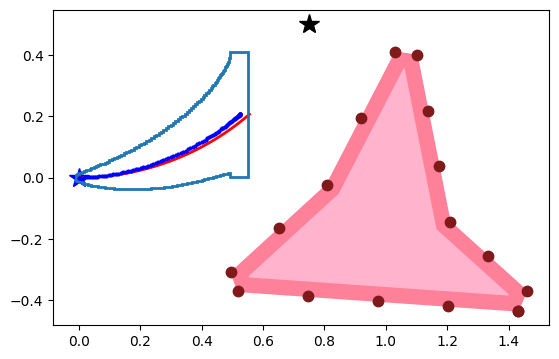

In [57]:
### Plot Everything
import matplotlib.pyplot as plt 
from immrax.utils import get_partitions_ut, run_times, draw_iarrays, gen_ics, draw_iarray

# robot desired location
x_des = 0.75
y_des = 0.5
z0 = z_curr
zx0 = z_curr[0]
zy0 = z_curr[1]
ZXs = Z_des[:,0]
ZYs = Z_des[:,1]
# obstacle = loadmat('export_for_verification/obstacle.mat')
# O = obstacle['O']
# O_buf = obstacle['O_buf']
# O_pts = obstacle['O_pts']

plt.figure(1) # Create a Figure
fig, ax = plt.subplots()

# ax.axis('equal') # Set aspect ratio to be equal
# ax.tick_params(axis='both', which='major', labelsize=15) # Adjust font size
ax.fill(O_buf[0], O_buf[1], color=[1, 0.5, 0.6]) # Plot the buffered obstacle
ax.fill(O[0], O[1], color=[1, 0.7, 0.8]) # Plot actual obstacle
ax.plot(O_pts[0,:], O_pts[1,:], '.', color=[0.5, 0.1, 0.1], markersize=15) # Plot discretized obstacle
ax.plot(x_des, y_des, 'k*', linewidth=2, markersize=15) # Plot the desired location of the robot
ax.plot(zx0, zy0, 'b*', linewidth=2, markersize=15) # Plot the current location of the robot
ax.plot(ZXs, ZYs, 'r', linewidth=2, markersize=15) # Plot the path of the robot

# for ix in ixx :
#     irx.utils.draw_iarray(ax, irx.ut2i(ix), zorder=2)
irx.utils.draw_iarrays(ax, [irx.ut2i(ix) for ix in ixx], zorder=2)

# for t in tfinite:
#     print(f"t: {t}")
#     print(f"xx[t]: {xx[t]}")
#     if isinstance(xx[t], irx.Interval) :
#         # print("hi")
#         ut_t = jnp.array(xx[t]).reshape(1,-1)
#         print(f"ut_t: {ut_t}")
#         boxes_t = [irx.ut2i(box) for box in ut_t] # Converted to intervals
#         print(f"boxes_t: {boxes_t}")
#         draw_iarrays(ax, boxes_t, zorder=2) # Draw the intervals on ax

#     else:
#         ax.plot(xx[t][0], xx[t][1], 'bo', markersize=2)
ax.plot(xx[:,0], xx[:,1], 'bo', markersize=2)
ax.set_aspect('equal', 'box')
# ax.axis('equal')
plt.show() # Show the plot


In [58]:
for t in tfinite:
    print(f"t: {t}")
    print(f"xx[t]: {xx[t]}")
    if isinstance(xx[t], irx.Interval) :
        # print("hi")
        ut_t = jnp.array(xx[t]).reshape(1,-1)
        print(f"ut_t: {ut_t}")
        boxes_t = [irx.ut2i(box) for box in ut_t] # Converted to intervals
        print(f"boxes_t: {boxes_t}")
        draw_iarrays(ax, boxes_t, zorder=2) # Draw the intervals on ax

    else:
        ax.plot(xx[t][0], xx[t][1], 'bo', markersize=2)
ax.set_aspect('equal', 'box')
# ax.axis('equal')
plt.show() # Show the plot

t: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]
xx[t]: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e-01]
 [5.09991217e-03 2.58679484e-05 1.00783408e-02 5.19999981e-01]
 [1.03992820e-02 1.06153093e-04 2.01556925e-02 5.39999962e-01]
 [1.58975087e-02 2.44872528e-04 3.02320682e-02 5.59999943e-01]
 [2.15939339e-02 4.46035963e-04 4.03074734e-02 5.79999924e-01]
 [2.74878349e-02 7.13644957e-04 5.03819212e-02 5.99999905e-01]
 [3.35784331e-02 1.05169252e-03 6.04554228e-02 6.19999886e-01]
 [3.98648866e-02 1.46416156e-03 7.05279708e-02 6.39999866e-01]
 [4.63462956e-02 1.95502467e-03 8.05995986e-02 6.59999847e-01]
 [5.30216955e-02 2.52824277e-03 9.06703025e-02 6.79999828e-01]
 [5.98900728e-02 3.18776513e-03 1.00740090e-01 6.99999809e-01]
 [6.694961